In [2]:
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import math
import json
import data_utils
import plot_utils
import keras_util

from sklearn.model_selection import *
from sklearn import metrics

import random

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('../../data/dataset/label_index.json', 'r') as f:
    label_index_dict = json.load(f)

In [4]:
dataset = np.load('../../data/dataset/atti_dataset.npz')

x_train = dataset['x_train']
y_train = dataset['y_train']

x_test = dataset['x_test']
y_test = dataset['y_test']

In [5]:
max_dimension = max(np.max(x_train))
max_dimension

52386

In [9]:
dimensions = 100

In [10]:
x_train = data_utils.filter_dataset(x_train, dimensions)
x_test = data_utils.filter_dataset(x_test, dimensions)

In [13]:
to_keep = [i for i in range(len(x_train)) if len(x_train[i]) > 0]

In [ ]:
for i in range(len(x_train)):
    if len(x_train[i]) == 0:
        
        print(x_train[i])

## Data Preparation

In [7]:
batch_size = 128
num_classes = len(set(y_train))
train_val_split = math.ceil(len(x_train) * 0.8)

In [8]:
train_val_split

117777

In [9]:
train_generator = data_utils.data_generator(
    x_train, y_train, dimensions, num_classes, batch_size, 0, train_val_split, True
)
val_generator = data_utils.data_generator(
    x_train, y_train, dimensions, num_classes, batch_size, train_val_split, len(x_train), True  
)

In [12]:
def build_model(neurons, num_features):
    keras_util.new_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neurons, activation='relu', input_shape=(num_features, )))
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(len(label_index_dict), activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [13]:
model = build_model(512, dimensions)

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               26812416  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 34)                17442     
Total params: 27,355,170
Trainable params: 27,355,170
Non-trainable params: 0
_________________________________________________________________


In [15]:
train_steps = train_val_split // batch_size + 1
val_steps = (len(x_train) - train_val_split) // batch_size + 1

In [16]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir="logs/dense_512")]

In [17]:
history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=5, 
                              validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

Epoch 1/5
921/921 [==============================] - 69s 74ms/step - loss: 0.9791 - acc: 0.6918 - val_loss: 0.8844 - val_acc: 0.7071
Epoch 2/5
921/921 [==============================] - 69s 74ms/step - loss: 0.4624 - acc: 0.8478 - val_loss: 0.8760 - val_acc: 0.7329
Epoch 3/5
921/921 [==============================] - 69s 74ms/step - loss: 0.3050 - acc: 0.9001 - val_loss: 0.8808 - val_acc: 0.7453
Epoch 4/5
921/921 [==============================] - 69s 74ms/step - loss: 0.2213 - acc: 0.9265 - val_loss: 0.9188 - val_acc: 0.7540
Epoch 5/5
921/921 [==============================] - 69s 75ms/step - loss: 0.1669 - acc: 0.9438 - val_loss: 0.9850 - val_acc: 0.7538


Prediction on the test set

In [18]:
test_steps = len(x_test) // batch_size + 1
test_generator = data_utils.data_generator(x_test, y_test, dimensions, num_classes, batch_size, 0, len(x_test))

In [40]:
model.evaluate_generator(test_generator, test_steps)

[0.9641757463878351, 0.7571424613038735]

In [19]:
test_predictions = model.predict_generator(test_generator, test_steps)

In [20]:
print(test_predictions.shape)
print(y_test.shape)

(36806, 34)
(36806,)


In [21]:
predictions = np.array([np.argmax(x) for x in test_predictions])

In [22]:
metrics.precision_recall_fscore_support(y_test,predictions, average='weighted')

(0.753081743865158, 0.7491441612780525, 0.7488277189514629, None)

In [23]:
metrics.accuracy_score(y_test, predictions)

0.7491441612780525

In [24]:
y_test_v = data_utils.to_one_hot(y_test, len(set(y_test)))

In [25]:
metrics.roc_auc_score(y_test_v, test_predictions, average='weighted')

0.9817663771852105

In [27]:
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.53      0.54      0.53       212
          1       0.70      0.29      0.41       228
          2       0.79      0.93      0.86       718
          3       0.66      0.77      0.71      3150
          4       0.74      0.75      0.74      2488
          5       0.66      0.61      0.64       306
          6       0.56      0.59      0.57       651
          7       0.51      0.41      0.45       350
          8       0.69      0.68      0.69       771
          9       0.79      0.72      0.75      1759
         10       0.70      0.67      0.69       777
         11       0.62      0.64      0.63      1037
         12       0.66      0.65      0.66      1177
         13       0.64      0.41      0.50       175
         14       0.93      0.94      0.93      2812
         15       0.79      0.64      0.71       432
         16       0.76      0.48      0.59       194
         17       0.96      0.90      0.93   

### Confusion Matrix

In [29]:
conf_matrix = metrics.confusion_matrix(y_test, predictions)

In [30]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)

Confusion matrix, without normalization


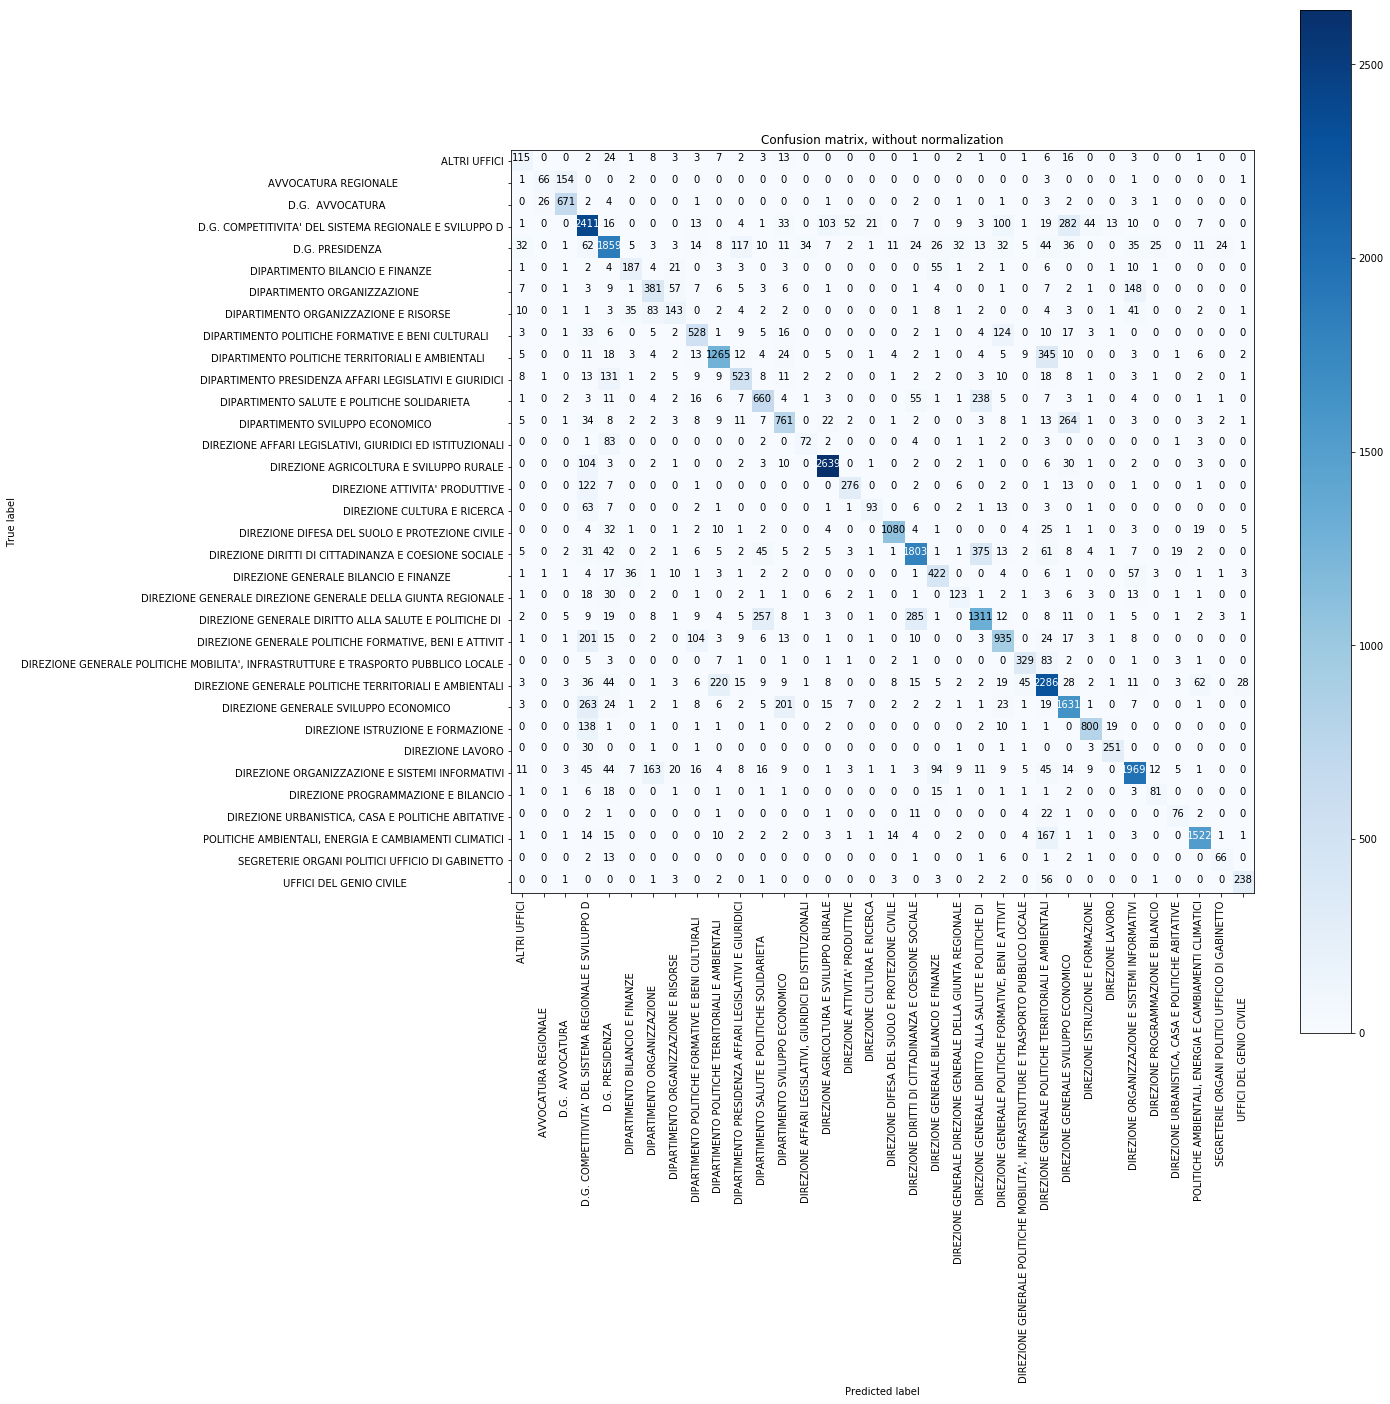

In [31]:
plt.rcParams['figure.figsize'] = (20,20)
plot_confusion_matrix(conf_matrix, classes=label_index_dict,
                      title='Confusion matrix, without normalization')